# Files for unit test

In [2]:
import numpy as np
import healpy as hp
import astropy.units as u

from histpy import Histogram

from cosipy import test_data
from cosipy.image_deconvolution import CoordsysConversionMatrix, SpacecraftAttitudeExposureTable, AllSkyImageModel, DataIF_COSI_DC2
from cosipy.spacecraftfile import SpacecraftFile

from cosipy.response import FullDetectorResponse

In [3]:
nside = 1

In [4]:
ori = SpacecraftFile.parse_from_file(test_data.path / "20280301_first_10sec.ori")
ori

# Exposure Table

In [41]:
nside = 1

exposure_table = SpacecraftAttitudeExposureTable.from_orientation(ori, nside=nside, start=ori.get_time()[0], stop=ori.get_time()[-1], min_exposure=0, min_num_pointings=1)

exposure_table


WARNING ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"


WARNING ErfaWarning: ERFA function "utctai" yielded 10 of "dubious year (Note 3)"



  0%|          | 0/10 [00:00<?, ?it/s]

,scatt_binning_index,healpix_index,zpointing,xpointing,zpointing_averaged,xpointing_averaged,delta_time,exposure,num_pointings,bkg_group
0,0,"(2, 0)","[[221.8702338996725, 16.87787163174393], [221....","[[41.87023389967253, 73.12212836825609], [41.8...","[221.97851537699194, 17.120386001590717]","[41.97917985691546, 72.87963751322992]","[0.9999999999969589, 0.9999999999969589, 1.000...",10.0,10,0


In [6]:
exposure_table.to_pickle(test_data.path / "image_deconvolution" / "exposure_table_test_nside1_ring.pickle")

In [7]:
exposure_table.save_as_fits(test_data.path / "image_deconvolution" / "exposure_table_test_nside1_ring.fits")

In [8]:
map_pointing_zx = exposure_table.calc_pointing_trajectory_map()

In [9]:
map_pointing_zx.write(test_data.path / "image_deconvolution" / "map_pointing_zx_test_nside1_ring.hdf5")

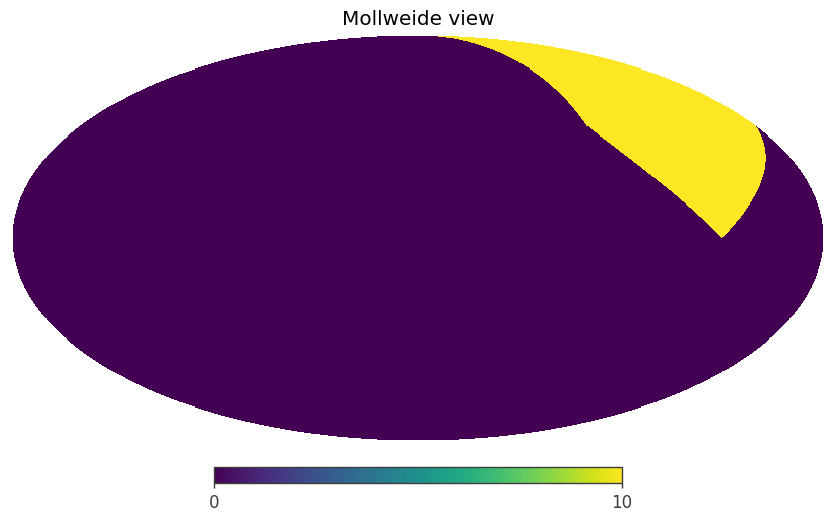

In [10]:
hp.mollview(map_pointing_zx.contents[:,0].todense())

# CoordsysConversionMatrix using time bins

In [11]:
full_detector_response = FullDetectorResponse.open(test_data.path / "test_full_detector_response.h5")

In [12]:
full_detector_response

FILENAME: '/Users/yoneda/Work/Exp/COSI/cosipy-2/soft/cosipy/cosipy/test_data/test_full_detector_response.h5'
AXES:
  NuLambda:
    DESCRIPTION: 'Location of the simulated source in the spacecraft coordinates'
    TYPE: 'healpix'
    NPIX: 12
    NSIDE: 1
    SCHEME: 'RING'
  Ei:
    DESCRIPTION: 'Initial simulated energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 10
    EDGES: [150.0 keV, 220.0 keV, 325.0 keV, 480.0 keV, 520.0 keV, 765.0 keV, 1120.0 keV, 1650.0 keV, 2350.0 keV, 3450.0 keV, 5000.0 keV]
  Em:
    DESCRIPTION: 'Measured energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 10
    EDGES: [150.0 keV, 220.0 keV, 325.0 keV, 480.0 keV, 520.0 keV, 765.0 keV, 1120.0 keV, 1650.0 keV, 2350.0 keV, 3450.0 keV, 5000.0 keV]
  Phi:
    DESCRIPTION: 'Compton angle'
    TYPE: 'linear'
    UNIT: 'deg'
    NBINS: 30
    EDGES: [0.0 deg, 6.0 deg, 12.0 deg, 18.0 deg, 24.0 deg, 30.0 deg, 36.0 deg, 42.0 deg, 48.0 deg, 54.0 deg, 60.0 deg, 66.0 deg, 72.0 deg, 78.0 deg, 84.0 deg, 90.0 deg, 96.0 deg

In [13]:
ccm = CoordsysConversionMatrix.time_binning_ccm(full_detector_response, ori, [ori.get_time()[0].value, ori.get_time()[-1].value] * u.s)

  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
ccm.axes['Time'].edges

<Quantity [1.83547800e+09, 1.83547801e+09] s>

In [15]:
ccm.write(test_data.path / "image_deconvolution" / 'ccm_time_test.hdf5')

# CoordsysConversionMatrix using ScAtt bins

In [16]:
ccm = CoordsysConversionMatrix.spacecraft_attitude_binning_ccm(full_detector_response, exposure_table)

  0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
ccm_use_averaged_pointing = CoordsysConversionMatrix.spacecraft_attitude_binning_ccm(full_detector_response, exposure_table, use_averaged_pointing = True)

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
ccm.write(test_data.path / "image_deconvolution" / 'ccm_scatt_use_averaged_pointing_False_test.hdf5')

In [19]:
ccm_use_averaged_pointing.write(test_data.path / "image_deconvolution" / 'ccm_scatt_use_averaged_pointing_True_test.hdf5')

# AllSkyImageModel

In [20]:
model = AllSkyImageModel(nside = nside, energy_edges = [100.0, 1000.0] * u.keV)
model[:] = 1.0 / u.s / u.sr / u.cm**2

In [21]:
model.write(test_data.path / "image_deconvolution" / 'all_sky_image_model_test_nside1.hdf5')

# Histogram in ScAtt Binning

In [42]:
from cosipy import response
from cosipy import test_data
from cosipy import BinnedData
from histpy import Histogram, Axes, Axis, HealpixAxis
from scoords import Attitude, SpacecraftFrame
from astropy.coordinates import SkyCoord, ICRS, Galactic, FK4, FK5
import astropy.units as u
import numpy as np
import healpy as hp

In [43]:
full_detector_response = response.FullDetectorResponse.open(test_data.path / "test_full_detector_response.h5")
full_detector_response

FILENAME: '/Users/yoneda/Work/Exp/COSI/cosipy-2/soft/cosipy/cosipy/test_data/test_full_detector_response.h5'
AXES:
  NuLambda:
    DESCRIPTION: 'Location of the simulated source in the spacecraft coordinates'
    TYPE: 'healpix'
    NPIX: 12
    NSIDE: 1
    SCHEME: 'RING'
  Ei:
    DESCRIPTION: 'Initial simulated energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 10
    EDGES: [150.0 keV, 220.0 keV, 325.0 keV, 480.0 keV, 520.0 keV, 765.0 keV, 1120.0 keV, 1650.0 keV, 2350.0 keV, 3450.0 keV, 5000.0 keV]
  Em:
    DESCRIPTION: 'Measured energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 10
    EDGES: [150.0 keV, 220.0 keV, 325.0 keV, 480.0 keV, 520.0 keV, 765.0 keV, 1120.0 keV, 1650.0 keV, 2350.0 keV, 3450.0 keV, 5000.0 keV]
  Phi:
    DESCRIPTION: 'Compton angle'
    TYPE: 'linear'
    UNIT: 'deg'
    NBINS: 30
    EDGES: [0.0 deg, 6.0 deg, 12.0 deg, 18.0 deg, 24.0 deg, 30.0 deg, 36.0 deg, 42.0 deg, 48.0 deg, 54.0 deg, 60.0 deg, 66.0 deg, 72.0 deg, 78.0 deg, 84.0 deg, 90.0 deg, 96.0 deg

In [44]:
analysis = BinnedData(test_data.path / "inputs_crab.yaml")
analysis

In [45]:
analysis.energy_bins = full_detector_response.axes['Em'].edges.to(u.keV).value
analysis.nside = full_detector_response.axes['PsiChi'].nside

assert np.all(full_detector_response.axes['Phi'].widths == full_detector_response.axes['Phi'].widths[0]) == True

analysis.phi_pix_size = full_detector_response.axes['Phi'].widths[0].to(u.deg).value

analysis.time_bins = 10 #s

In [50]:
def get_binned_data_scatt(unbinned_event, exposure_table, psichi_binning = 'local', sparse = False):
    exposure_dict = {row['healpix_index']: row['scatt_binning_index'] for _, row in exposure_table.iterrows()}
        
    # from BinnedData.py
 
    # Get energy bins:
    energy_bin_edges = np.array(unbinned_event.energy_bins)
    
    # Get phi bins:
    number_phi_bins = int(180./unbinned_event.phi_pix_size)
    phi_bin_edges = np.linspace(0,180,number_phi_bins+1)
    
    # Define psichi axis and data for binning:
    if psichi_binning == 'galactic':
        psichi_axis = HealpixAxis(nside = unbinned_event.nside, scheme = unbinned_event.scheme, coordsys = 'galactic', label='PsiChi')
        coords = SkyCoord(l=unbinned_event.cosi_dataset['Chi galactic']*u.deg, b=unbinned_event.cosi_dataset['Psi galactic']*u.deg, frame = 'galactic')
    if psichi_binning == 'local':
        psichi_axis = HealpixAxis(nside = unbinned_event.nside, scheme = unbinned_event.scheme, coordsys = SpacecraftFrame(), label='PsiChi')
        coords = SkyCoord(lon=unbinned_event.cosi_dataset['Chi local']*u.rad, lat=((np.pi/2.0) - unbinned_event.cosi_dataset['Psi local'])*u.rad, frame = SpacecraftFrame())

    # Define scatt axis and data for binning
    n_scatt_bins = len(exposure_table)
    scatt_axis = Axis(np.arange(n_scatt_bins + 1), label='ScAtt')
    
    is_nest = True if exposure_table.scheme == 'nested' else False
    
    nside_scatt = exposure_table.nside
    
#    zindex = hp.ang2pix(nside_scatt, unbinned_event.cosi_dataset['Zpointings (glon,glat)'].T[0] * 180 / np.pi, 
#                        unbinned_event.cosi_dataset['Zpointings (glon,glat)'].T[1] * 180 / np.pi, nest=is_nest, lonlat=True)
#    xindex = hp.ang2pix(nside_scatt, unbinned_event.cosi_dataset['Xpointings (glon,glat)'].T[0] * 180 / np.pi, 
#                        unbinned_event.cosi_dataset['Xpointings (glon,glat)'].T[1] * 180 / np.pi, nest=is_nest, lonlat=True)    
#    scatt_data = np.array( [ exposure_dict[(z, x)] + 0.5 if (z,x) in exposure_dict.keys() else -1 for z, x in zip(zindex, xindex)] ) # should this "0.5" be needed?

    # NOTE: test_data.path / "unbinned_data_MEGAlib_calc.hdf5" is written in a old format!!!
    zindex = hp.ang2pix(nside_scatt, unbinned_event.cosi_dataset['Zpointings'].T[0] * 180 / np.pi, 
                        unbinned_event.cosi_dataset['Zpointings'].T[1] * 180 / np.pi, nest=is_nest, lonlat=True)
    xindex = hp.ang2pix(nside_scatt, unbinned_event.cosi_dataset['Xpointings'].T[0] * 180 / np.pi, 
                        unbinned_event.cosi_dataset['Xpointings'].T[1] * 180 / np.pi, nest=is_nest, lonlat=True)    
    scatt_data = np.array( [ exposure_dict[(z, x)] + 0.5 if (z,x) in exposure_dict.keys() else -1 for z, x in zip(zindex, xindex)] ) # should this "0.5" be needed?
    
    # Initialize histogram:
    binned_data = Histogram([scatt_axis,
                              Axis(energy_bin_edges*u.keV, label='Em'),
                              Axis(phi_bin_edges*u.deg, label='Phi'),
                              psichi_axis],
                              sparse=sparse)

    # Fill histogram:
    binned_data.fill(scatt_data, unbinned_event.cosi_dataset['Energies']*u.keV, np.rad2deg(unbinned_event.cosi_dataset['Phi'])*u.deg, coords)    
    
    return binned_data

In [51]:
analysis.cosi_dataset = analysis.get_dict_from_hdf5(test_data.path / "unbinned_data_MEGAlib_calc.hdf5")

In [54]:
binned_signal = get_binned_data_scatt(analysis, exposure_table, psichi_binning = 'local', sparse = False)

In [56]:
binned_signal.write(test_data.path / "image_deconvolution" / 'test_event_histogram_localCDS_scatt.h5')